# Explore the ADL dataset

## Script Summary

This notebook explores the parts of the ADL (Archive for Danish Literature) dataset that are in the public domain. The dataset contains Danish literary texts that can be analyzed using various text mining techniques.

**Steps:**
- Load the ADL dataset from a CSV file and inspect its structure
- Explore the dataset by counting texts per year and per author
- Calculate word counts per author to identify the most prolific writers
- Clean text data using regex methods to remove numbers, short words, and normalize formatting
- Remove stopwords to prepare text for analysis
- Perform collocation analysis to identify words that frequently appear near specific keywords (e.g., 'fader', 'moder', 'barn')
- Visualize collocations using bar charts

**Outputs:** Cleaned text data, collocation analysis results, and visualizations showing semantic patterns and linguistic relationships in Danish literary texts.

**Dataset:** To download the dataset follow go to the [Library's Open Access Repository](https://loar.kb.dk/handle/1902/49121).

**Digital Collection:** To close read the texts in ADL go to the [ADL Collection](https://tekster.kb.dk/text?editorial=no&f%5Bsubcollection_ssi%5D%5B%5D=adl&match=one&search_field=Alt). 

---

In [ ]:
## Import modules
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

## Read the CSV file

Load the dataset from a CSV file into a pandas DataFrame


In [ ]:
df = pd.read_csv('adl_dataset.csv', encoding='utf-8')

## Explore the data

Count the number of texts per year and display the top 10 years with the most texts

In [ ]:
df.value_counts('year').to_frame().reset_index().head(10)

year  count
0  1904     17
1  1920      8
2  1902      6
3  1901      6
4  1889      6
5  1921      5
6  1851      4
7  1912      4
8  1928      4
9  1926      4

Count the number of texts per author and display the top 10 authors with the most texts

In [ ]:
df.value_counts('author').to_frame().reset_index().head(10)

author  count
0        Larsen, Karl.     18
1        Hjortø, Knud.     16
2     Brandes, Edvard.     13
3         Rode, Helge.     12
4   Michaëlis, Sophus.     11
5  Grundtvig, N. F. S.     10
6   Skjoldborg, Johan.      8
7  Schandorph, Sophus.      8
8        Bang, Herman.      7
9       Hertz, Henrik.      5

Calculate the total word count for each author and display the top 10 authors with the most words across all their texts.


In [ ]:
# Define a function to count words in a text using regex
def word_count(text):
    return len(re.findall(r'\b\S+\b', text))

# Add a new column with word count for each text
df['word_count'] = df['text'].apply( lambda x : word_count(x)) 

# Group by author, sum word counts, and display the top 10 authors
df.groupby('author')['word_count'].sum()\
                                .to_frame()\
                                .sort_values('word_count', ascending=False)\
                                .reset_index()\
                                .head(10)

author  word_count
0      Grundtvig, N. F. S.     2148585
1      Schandorph, Sophus.     1209914
2            Hjortø, Knud.      886864
3            Bang, Herman.      843214
4            Larsen, Karl.      642502
5          Brandes, Georg.      627489
6  Heiberg, Johanne Luise.      395598
7       Michaëlis, Sophus.      389488
8         Brandes, Edvard.      362533
9           Kidde, Harald.      359522

## Clean the text

To get more uniform text data, regex methods are used. The `.findall()` method with regex `'\b\S+\b'` finds all data between word boundaries that is not whitespace. The `.sub()` method removes numbers, words containing numbers, words with a length of 1 or 2, and any sequences of more than one whitespace. Finally, the letters are converted to lowercase to return the clean text. 

In [ ]:
# Make a function to clean the text using regular expressions
def clean(text): 
    
    text = ' '.join(re.findall(r'\b\S+\b', text))

    # Remove numbers and words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    
    # Remove short words (length 1 or 2)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text) 

    # Convert text to lowercase
    text = text.lower()

    # return the text
    return text
    
# Apply the cleaning function to the text column
df['clean_text'] = df['text'].apply(lambda x: clean(x))

## Remove stopwords

To apply collocation analysis downstream, stopwords should be excluded to improve the results. Therefore, new text strings without stopwords are created.

A text file containing stopwords is loaded from the file system. The file is read into the script and converted into a list. Additional stopwords, punctuation marks, or special characters can be added to the list as needed. 

In [ ]:
# Load a list of danish stopwords from a text file
sw_file = 'adl_dataset_stopwords.txt'

with open(sw_file, 'r', encoding='utf-8') as f:
    stop_words = f.read().split()
    # Add additional stopwords
    stop_words.extend(['_', '/', "'"])

# Define a function to remove stopwords from the text
def remove_stopwords(clean_text):   
    # Change text to wordlist
    tokens = clean_text.split()
    tokens_wo_stopwords = [i for i in tokens if i.lower() not in stop_words]
    clean_text_wo_stopwords = ' '.join(tokens_wo_stopwords)
    return clean_text_wo_stopwords

# Apply the stopword removal function
df['clean_text_wo_stopwords'] = df['clean_text'].apply( lambda x : remove_stopwords(x))

## Collocation

This section performs collocation analysis to identify words that frequently appear near specific keywords in the corpus. Collocations are words that tend to co-occur with your target keywords, and it is a helpfull method to reveal semantic patterns, themes, and linguistic relationships in the text.

In [ ]:
# Define keywords for collocation analysis
keywords = ['fader', 'moder', 'barn']

in_data_list = ' '.join(df['clean_text_wo_stopwords']).split()

# Initialize a dictionary to count keyword proximities
keyword_proximity_counts = {keyword: Counter() for keyword in keywords}
window_size = 10

# Count the proximity of words around each keyword
for i, token in enumerate(in_data_list):
    if token in keywords:
        # Define the window around the keyword
        start = max(0, i - window_size)
        end = min(len(in_data_list), i + window_size + 1)
        # Count terms in the window, excluding the keyword itself
        for j in range(start, end):
            if j != i:
                keyword_proximity_counts[token][in_data_list[j]] += 1

# Filter out terms with low counts
filtered_keyword_proximity_counts = {
    keyword: Counter({term: count for term, count in counts.items() if count >= 80})
    for keyword, counts in keyword_proximity_counts.items()}

## Visualise the collocations
The content of the variable `filtered_keyword_proximity_counts` shows the different keywords together with their collocations. These collocations are the results after stopwords have been removed and a window size of 10 has been defined. To make the data easier to interpret, matplotlib is used to visualise the collocations with bar plots.

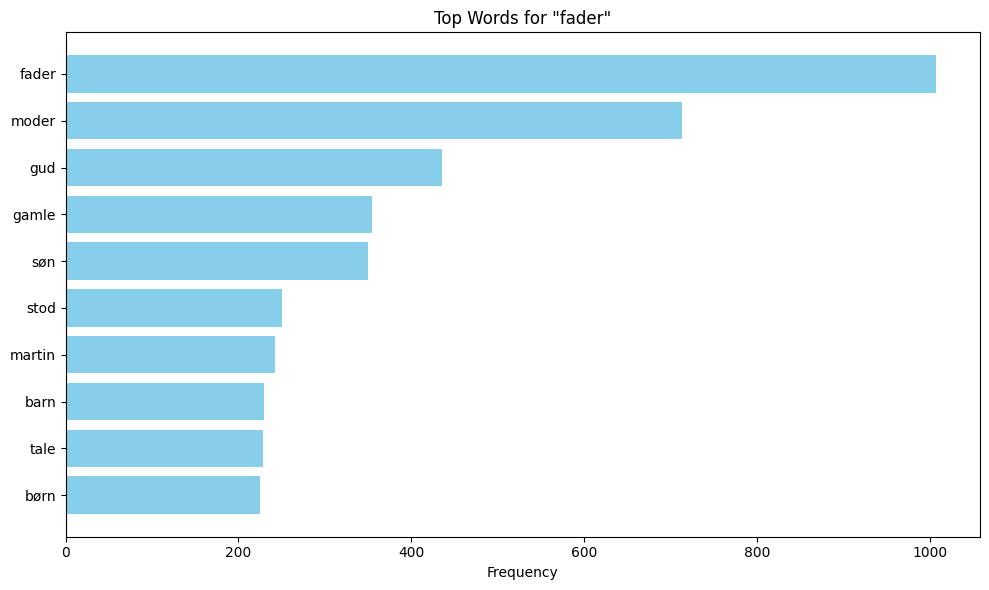

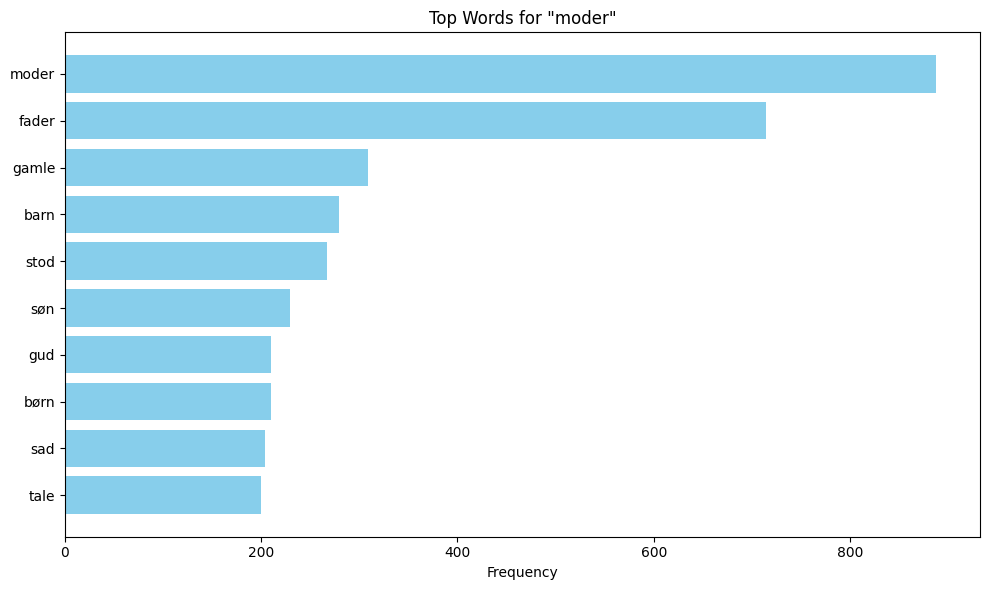

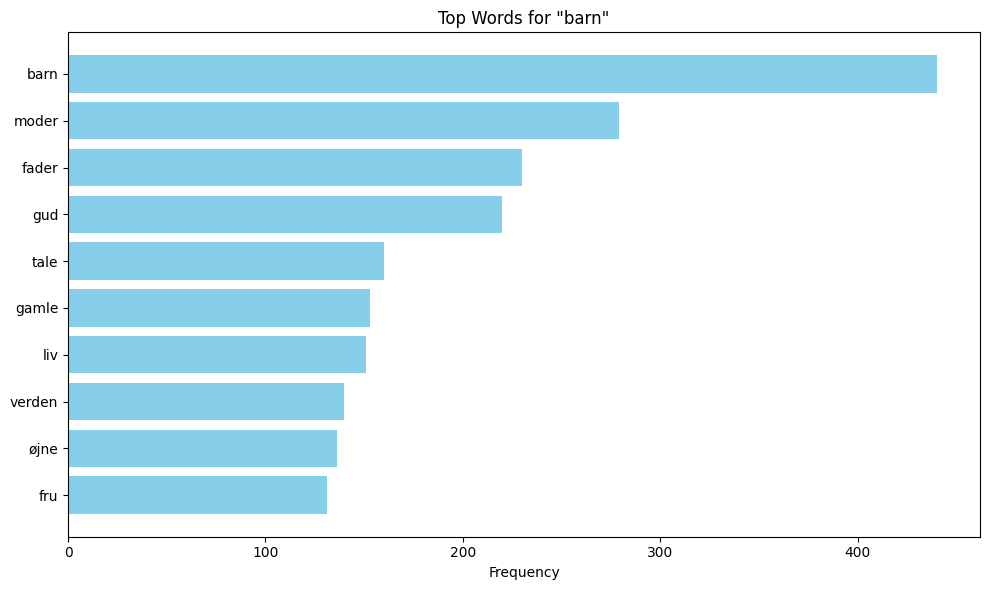

In [ ]:
# Convert each group's Counter to a DataFrame
dfs = []
for keyword, counter in filtered_keyword_proximity_counts.items():
    df = pd.DataFrame(counter.items(), columns=['Word', 'Frequency'])
    df['Keyword_Group'] = keyword
    dfs.append(df)

# Concatenate all dataframes
all_data = pd.concat(dfs, ignore_index=True)

# Create individual bar charts for each keyword group
for keyword in filtered_keyword_proximity_counts.keys():
    df_subset = all_data[all_data['Keyword_Group'] == keyword]
    plt.figure(figsize=(10,6))
    df_subset = df_subset.sort_values(by='Frequency', ascending=False).head(10)
    plt.barh(df_subset['Word'], df_subset['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top Words for "{keyword}"')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


## Other studies

The ADL dataset invites several complementary lines of inquiry beyond the current collocation analysis:

- Expand the keyword list to explore other thematic clusters (e.g., emotions, nature, social relationships) and compare collocation patterns across different semantic domains.
- Analyze temporal changes in vocabulary and collocations by comparing texts from different time periods to identify linguistic evolution.
- Investigate author-specific collocation patterns to see if certain authors have distinctive linguistic styles or preferred word combinations.
- Apply topic modeling techniques (e.g., LDA) to discover latent themes across the corpus.
- Compare collocation patterns between different genres or literary movements represented in the dataset.
- Explore gender-specific language patterns by analyzing collocations in texts written by male versus female authors.
- Investigate the relationship between word frequency and collocation strength to identify both common and distinctive linguistic patterns.
